_Ce notebook présente une démarche complète de machine learning sur un dataset imposé: préparation des données, ajustement de plusieurs modèles, validation croisée et sélection de modèle_

# Machine Learning

In [263]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error as mae

In [264]:
np.random.seed(8184)

## Les données

### Présentation et importation

Les données qui nous ont été confiées proviennent du site [Kaggle](https://www.kaggle.com/competitions/santander-value-prediction-challenge/overview) et ont été déposées par la banque __Santander__.

Le challenge associé à ce jeu de données consistait à prédire la valeur des transactions de clients anonymisés (variable _target_) en fonction d'un grand nombre de variables elles aussi anonymisées.

__Note importante :__ nos résultats sur ce jeu de données sont très en-deça des meilleurs scores de prédiction obtenus sur Kaggle, la raison étant que ces données nécessitent en réalité d'être décodées selon une logique particulière découverte de façon collaborative par les kagglers lorsque le challenge était encore actif. Ici nous faisons l'économie de ce décodage, le but de l'exercice étant davantage de mettre en oeuvre une démarche de machine learning cohérente que d'obtenir des prédictions de grande qualité.

In [265]:
data = pd.read_csv('train.csv', index_col='ID')

In [266]:
print(data.head(10))

               target  48df886f9  0deb4b6a8  34b15f335  a8cb14b00  2f0771a37  \
ID                                                                             
000d6aaf2  38000000.0        0.0          0        0.0          0          0   
000fbd867    600000.0        0.0          0        0.0          0          0   
0027d6b71  10000000.0        0.0          0        0.0          0          0   
0028cbf45   2000000.0        0.0          0        0.0          0          0   
002a68644  14400000.0        0.0          0        0.0          0          0   
002dbeb22   2800000.0        0.0          0        0.0          0          0   
003925ac6    164000.0        0.0          0        0.0          0          0   
003eb0261    600000.0        0.0          0        0.0          0          0   
004b92275    979000.0        0.0          0        0.0          0          0   
0067b4fef    460000.0        0.0          0        0.0          0          0   

           30347e683  d08d1fbe3  6ee66e

In [267]:
data.shape

(4459, 4992)

Le jeu de données contient __4992__ variables observées pour __4459__ clients.

Ceci implique que le problème à traiter est en grande dimension ($p$ le nombre de variables est proche de $n$ le nombre d'observations).

Il faudra par conséquent recourir à une technique de réduction de la dimension.

### Variable cible

La variable cible est quantitative, on se trouve donc en présence d'un problème de régression.

In [268]:
data.target.describe()

count    4.459000e+03
mean     5.944923e+06
std      8.234312e+06
min      3.000000e+04
25%      6.000000e+05
50%      2.260000e+06
75%      8.000000e+06
max      4.000000e+07
Name: target, dtype: float64

### Variables explicatives

Les premières lignes du jeu de données ont montré la présence d'un grand nombre de zéros dans chaque colonne.

Les lignes suivantes montrent que seulement 5% des variables ont au moins 10% de valeurs non-nulles.

In [269]:
data.iloc[:, 1:].astype(bool).sum(axis=1).sort_values(ascending=False)

ID
6726fff18    1989
d94655f86    1971
1df3ca92e    1957
d8e48b069    1935
24204cd10    1907
             ... 
08cb967e3       1
511749abd       1
4cd26c425       1
b81878d2f       1
83a3de795       1
Length: 4459, dtype: int64

In [270]:
print(f"Proportion de variables contenant au moins 10% de valeurs non nulles : {round(np.sum(data.iloc[:, 1:].astype(bool).sum(axis=1) >= len(data)*0.1)/len(data)*100, 1)}%")

Proportion de variables contenant au moins 10% de valeurs non nulles : 5.5%


<AxesSubplot:>

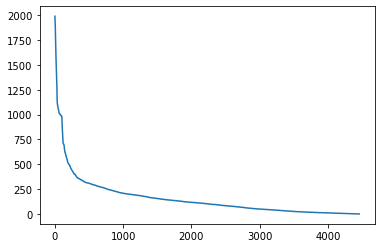

In [271]:
# Nombre de valeurs non nulles par colonne
data.iloc[:, 1:].astype(bool).sum(axis=1).sort_values(ascending=False).plot(use_index=False)

### Pré-traitement des données

Pour des raisons de lisibilité, on divise toutes les valeurs par $10^6$.

In [272]:
data = data/10**6

On sépare ensuite nos données entre _features_ et _target_.

In [273]:
X = data.iloc[:, 1:]
y = data.target

On procède à une analyse en composantes principales afin de réduire la dimension de nos données.

Les variables initiales sont ainsi remplacées par des variables synthétiques appelées composantes, chacune correspondant à une combinaison linéaire des premières.

Plutôt que de déterminer en amont un nombre donné de composantes, on fait en sorte de retenir les plus importantes jusqu'à rendre compte de 70% de la variance observée dans les données (argument _n\_components = 0.7_).

On obtient finalement un dataset contenant 72 variables au lieu de 4992 précédemment.

In [274]:
acp = PCA(n_components=0.7, svd_solver='full')
X_acp = acp.fit_transform(X)
X_acp

array([[-15.24573702,  -0.55002431,  -0.36375228, ...,   6.98820357,
          5.69765718,  -2.74241481],
       [-21.47430351,  -0.70142301,  -0.39938808, ...,   0.50034667,
         -7.04504471,  -4.03360171],
       [-29.0711814 ,  -0.7491836 ,  -0.47124769, ...,  -0.66293498,
          1.23419815,   0.23046207],
       ...,
       [ 31.70553188,  -0.89457171,  -0.57463577, ..., -10.71196731,
         18.52930087,  25.09003741],
       [-27.47296515,  -0.74772298,  -0.4718817 , ...,  -0.53196713,
          1.93718608,   0.34904242],
       [ -0.38684198,  -0.93440869,  -0.56083976, ...,   0.9907178 ,
          0.47078255,   0.24363931]])

In [275]:
X_acp.shape

(4459, 72)

Le jeu de données ainsi transformé est ensuite séparé en ensemble d'apprentissage et ensemble de test.

In [276]:
X_train, X_test, y_train, y_test = train_test_split(X_acp, y, random_state=42)

## Comparaison de modèles et optimisation des hyperparamètres

Après avoir testé de nombreux modèles à la main, nous avons décidé d'en retenir trois : 
- la régression Lasso qui nous servira de base; 
- la forêt aléatoire ;
- le boost de gradient.

Pour chacun de ces modèles, nous allons procéder à une validation-croisée afin de débusquer les meilleurs valeurs de paramètres et d'obtenir un score sur la base duquel comparer la qualité des prédictions obtenues.

### Régression Lasso

La régression Lasso consiste à appliquer une pénalité L1 à la fonction de perte du modèle de régression linéaire multiple.
Cette pénalité permet d'adapter les coefficients $\beta$ de la régression en fonction de l'importance des variables explicatives.

La pénalité est associée à un paramètre exogène $\alpha$ qu'il s'agit d'optimiser. On commence par visualiser l'évolution du $R^2$ en faisant évoluer $\alpha$ de 0 à 10 avec un pas de 0.1.

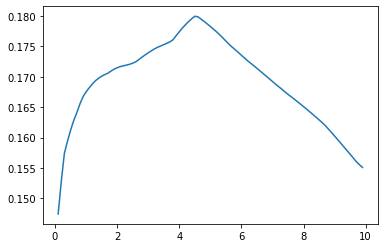

In [277]:
scores = {}
for alpha in np.arange(.1, 10, .1):
    lasso = Lasso(alpha)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    scores[round(alpha, 1)] = lasso.score(X_test, y_test)
plt.plot(scores.keys(), scores.values())

Constatant que le $R^2$ maximum est obtenu sur nos données de test pour un alpha compris entre 4 et 5, on procède à une validation croisée sur nos données d'apprentissage découpées en 10 plis : le modèle est successivement ajusté sur 9 plis puis la qualité de la prédiction est testé sur le pli restant.

In [278]:
scores = {}

for alpha in np.arange(4, 5, 0.01):
    score_lasso = cross_val_score(Lasso(alpha),
                                   X_train,
                                   y_train,
                                   cv=10,
                                   scoring='r2')
    scores[round(alpha, 2)] = np.mean(score_lasso)
    
print(f'\nR2 moyen maximal : {max(scores.values())} \tAtteint pour alpha = {max(scores, key=scores.get)}')


R2 moyen maximal : 0.12883213255733864 	Atteint pour alpha = 4.66


Le meilleur score est obtenu pour $\alpha = 4.66$ et nous indique qu'en moyenne, le modèle employé avec cette valeur d'hyperparamètre explique 12.9% de la variation observée dans la variable cible.

### Forêt aléatoire

On procède de la même manière avec le modèle de _random forest_ en optimisant le paramètre _max\_features_ qui indique quelle proportion des variables présentes dans le dataset doit être sélectionné à chaque ajustement d'un nouvel arbre de décision.

In [279]:
grid = {'n_estimators': [100], # plusieurs valeurs ont été testées, on ne conserve que la meilleure ici pour accélérer l'exécution
       'max_features' : [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]}

rfCross = GridSearchCV(estimator=RandomForestRegressor(),
                         param_grid=grid,
                         scoring='r2',
                         n_jobs=-1,
                         cv=10
                        )

rfCross.fit(X_train, y_train)

print(f"\nR2 moyen maximal : {rfCross.best_score_} \tAtteint pour max_features = {rfCross.best_params_['max_features']} et n_estimators = {rfCross.best_params_['n_estimators']}")


R2 moyen maximal : 0.2051234573175102 	Atteint pour max_features = 0.4 et n_estimators = 100


Pour max_features = 0.4, on constate une amélioration du $R^2$ par rapport au modèle précédent puisque c'est désormais près de 20.5% de la variance qui est expliquée par le modèle.

### Boosting de gradient

In [ ]:
grid = {'max_features' : [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
        'learning_rate' : np.arange(.05, 0.15, .01)}

gbCross = GridSearchCV(estimator=GradientBoostingRegressor(),
                         param_grid=grid,
                         scoring='r2',
                         n_jobs=-1,
                         cv=10
                        )

gbCross.fit(X_train, y_train)

print(f"\nR2 moyen maximal : {gbCross.best_score_} \tAtteint pour max_features = {gbCross.best_params_['max_features']} et learning_rate = {gbCross.best_params_['learning_rate']}")

Le score obtenu est légérement inférieur à celui du modèle de forêt aléatoire.

__Le modèle de random forest est donc retenu avec l'hyperparamètre optimal max_features=0.4.__

## Application du meilleur modèle à l'ensemble de test

In [286]:
rf = RandomForestRegressor(max_features=0.4)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.24736531444994891

In [287]:
mae(rf.predict(X_test), y_test)

4.94474303603988

__Les méthodes que nous avons utilisées ici ont donc été d'une efficacité limitée puique notre meilleur modèle ne nous a permis d'expliquer qu'un peu moins de 25% de la variation observée dans les transactions des clients à partir des données disponibles. En moyenne, nos prédictions montrent un écart absolu de l'ordre de 5 millions par rapport aux valeurs réelles.__

__Néanmoins, notre modèle ne montre pas de surapprentissage dans la mesure où le score obtenu sur nos données test est du même ordre que celui observé pendant la phase de validation croisée.__